# Quickstart Example with Synthetic Bandit Data
---
This notebook provides an example of conducting OPE of several different evaluation policies with synthetic bandit feedback data.

Our example with synthetic bandit data contains the follwoing four major steps:
- (1) Synthetic Data Generation
- (2) Off-Policy Learning
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

Please see [../examples/synthetic](../synthetic) for a more sophisticated example of the evaluation of OPE with synthetic bandit data.

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression
# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_reward_function,
    linear_behavior_policy
)
from obp.policy import IPWLearner, Random
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)

In [2]:
# obp version
print(obp.__version__)

0.3.3


## (1) Synthetic Data Generation
We prepare easy-to-use synthetic data generator: `SyntheticBanditDataset` class in the dataset module.

It takes number of actions (`n_actions`), dimension of context vectors (`dim_context`), reward function (`reward_function`), and behavior policy (`behavior_policy_function`) as inputs and generates a synthetic bandit dataset that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [3]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function and `linear_behavior_policy` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
)
# obtain training and test sets of synthetic logged bandit feedback
n_rounds_train, n_rounds_test = 100000, 100000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_train)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test)

# `bandit_feedback` is a dictionary storing synthetic logged bandit feedback
bandit_feedback_train

{'n_rounds': 100000,
 'n_actions': 10,
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [ 1.36946256,  0.58727761, -0.69296769, -0.27519988, -2.10289159],
        [-0.27428715,  0.52635353,  1.02572168, -0.18486381,  0.72464834],
        [-1.25579833, -1.42455203, -0.26361242,  0.27928604,  1.21015571]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([7, 4, 0, ..., 7, 9, 6]),
 'position': array([0,

## (2) Off-Policy Learning
After generating synthetic data, we now train some candidate evaluation policies using the training bandit dataset. <br>

We use *IPW Learner* implemented in the policy module to train evaluation policies. 
We also use *RandomForestClassifier* and *LogisticRegression* implemented in scikit-learn for base machine learning methods.

In [4]:
# define IPWLearner with Logistic Regression as its base ML model
ipw_lr = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LogisticRegression(C=100, random_state=12345)
)
# train IPWLearner on the training set of the synthetic logged bandit feedback
ipw_lr.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
# obtains action choice probabilities for the test set of the synthetic logged bandit feedback
action_dist_ipw_lr = ipw_lr.predict(context=bandit_feedback_test["context"])

In [5]:
# define IPWLearner with Random Forest as its base ML model
ipw_rf = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=RandomForest(n_estimators=30, min_samples_leaf=10, random_state=12345)
)
# train IPWLearner on the training set of the synthetic logged bandit feedback
ipw_rf.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
# obtains action choice probabilities for the test set of the synthetic logged bandit feedback
action_dist_ipw_rf = ipw_rf.predict(context=bandit_feedback_test["context"])

In [6]:
# define Uniform Random Policy as a baseline evaluation policy
random = Random(n_actions=dataset.n_actions,)

# compute the action choice probabililties for the test set of the synthetic logged bandit feedback
action_dist_random = random.compute_batch_action_dist(
    n_rounds=bandit_feedback_test["n_rounds"]
)

## (3) Off-Policy Evaluation (OPE)
Our next step is OPE which attempts to estimate the performance of evaluation policies using the logged bandit feedback and OPE estimators.

Here, we use the **InverseProbabilityWeighting (IPW)**, **DirectMethod (DM)**, and **Doubly Robust (DR)** estimators and visualize the OPE results.

In [7]:
# estimate the mean reward function by using ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    action_context=dataset.action_context,
    base_model=LogisticRegression(random_state=12345),
)
# please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback_test["context"],
    action=bandit_feedback_test["action"],
    reward=bandit_feedback_test["reward"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

In [8]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_test,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.787104          0.771925          0.807702
dm   0.644029          0.642926          0.645100
dr   0.779419          0.771589          0.788061 



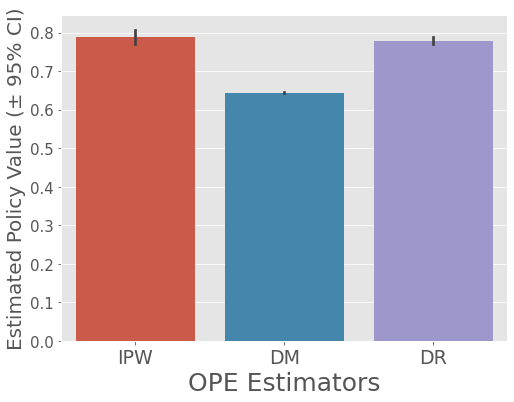

In [9]:
# estimate the policy value of IPWLearner with Logistic Regression
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    action_dist=action_dist_ipw_lr,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_a, '\n')
# visualize estimated policy values of IPWLearner with Logistic Regression by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_ipw_lr,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.719964          0.705208          0.735488
dm   0.627243          0.626011          0.628451
dr   0.721119          0.713220          0.729274 



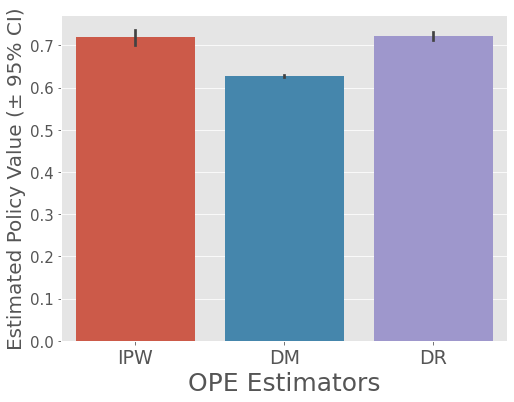

In [10]:
# estimate the policy value of IPWLearner with Random Forest by OPE estimators
estimated_policy_value_b, estimated_interval_b = ope.summarize_off_policy_estimates(
    action_dist=action_dist_ipw_rf,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_b, '\n')
# visualize estimated policy values of IPWLearner with Random Forest by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_ipw_rf,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.606821          0.603119          0.610232
dm   0.607460          0.605850          0.608856
dr   0.607458          0.604074          0.610561 



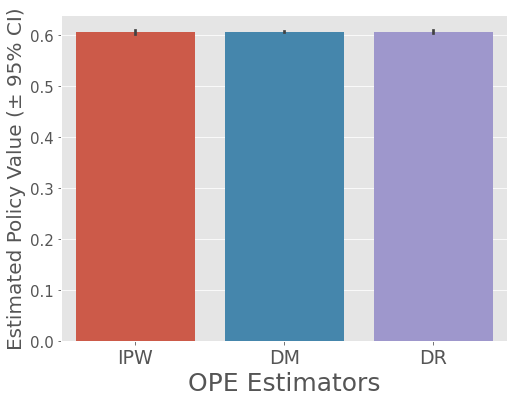

In [11]:
# estimate the policy value of Uniform Random
estimated_policy_value_c, estimated_interval_c = ope.summarize_off_policy_estimates(
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_c, '\n')
# visualize estimated policy values of Uniform Random by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

Our OPE procedure estimates that IPWLearners largely outperform the Uniform Random policy.

Moreover, IPWLearner with Random Forest seems to be the best one.

## (4) Evaluation of OPE estimators
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

With synthetic data, we can calculate the policy value of the evaluation policies. 
Therefore, we can compare the policy values estimated by OPE estimators with the ground-turths to evaluate the accuracy of OPE.

In [12]:
# we first calculate the policy values of the three evaluation policies using the expected rewards of the test data
expected_rewards = bandit_feedback_test['expected_reward']
ground_truth_ipw_lr = np.average(expected_rewards, weights=action_dist_ipw_lr[:, :, 0], axis=1).mean()
ground_truth_ipw_rf = np.average(expected_rewards, weights=action_dist_ipw_rf[:, :, 0], axis=1).mean()
ground_truth_random = np.average(expected_rewards, weights=action_dist_random[:, :, 0], axis=1).mean()

print(f'policy value of IPWLearner with Logistic Regression: {ground_truth_ipw_lr}')
print(f'policy value of IPWLearner with Random Forest: {ground_truth_ipw_rf}')
print(f'policy value of Unifrom Random: {ground_truth_random}')

policy value of IPWLearner with Logistic Regression: 0.7786813586555181
policy value of IPWLearner with Random Forest: 0.7153689867552405
policy value of Unifrom Random: 0.606060477451349


In fact, IPWLearner with Random Forest reveals the best performance among the three evaluation policies.

Using the above ground-truths, we evaluate the estimation accuracy of the estimators.

In [13]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values of IPWLearner with Logistic Regression and its ground-truth.
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performances of given estimators 
relative_ee_a = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_ipw_lr,
    ),
    action_dist=action_dist_ipw_lr,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_a

,relative-ee
ipw,0.012090
dm,0.172946
dr,0.000967


In [14]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of IPWLearner with Random Forest and its ground-truth.
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performances of given estimators 
relative_ee_b = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_ipw_rf,
    ),
    action_dist=action_dist_ipw_rf,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_b

,relative-ee
ipw,0.004777
dm,0.123164
dr,0.009270


In [15]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of Uniform Random and its ground-truth.
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performances of given estimators 
relative_ee_c = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_random,
    ),
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_c

,relative-ee
ipw,0.001044
dm,0.002237
dr,0.002179


Please see [../examples/synthetic](../synthetic) for a more sophisticated example of the evaluation of OPE with synthetic bandit data.